In [7]:
import csv
import subprocess
import shlex
import json
import re

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown

In [8]:
TIMING_PATTERN = re.compile(r"The simulation finished at time (\d+\.\d+) after (\d+) steps.")

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

In [14]:
def simulate_time_steps(algorithm, speciation=0.1, seeds=[42], sample=1.0, size=100, radius=564, sigma=10.0):
    times = []
    steps = []
    
    for seed in seeds:
        config = "".join(f"""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: AlmostInfinite(
                radius: {radius},
                sigma: {sigma},
            ),

            reporters: [],
        )
        """.split()).replace(",)", ")").replace(",]", "]")

        # Run the simulation
        result = subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True)

        match = TIMING_PATTERN.search(result.stdout)

        times.append(float(match.group(1)))
        steps.append(int(match.group(2)))
    
    times = np.array(times)
    steps = np.array(steps)
    
    plt.title(f"{algorithm}: Times")
    plt.hist(times)
    plt.show()
    
    plt.title(f"{algorithm}: Steps")
    plt.hist(steps)
    plt.show()

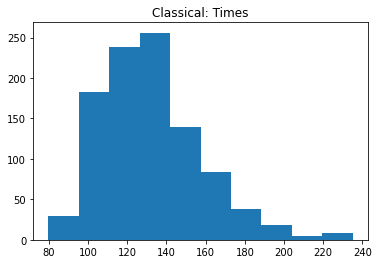

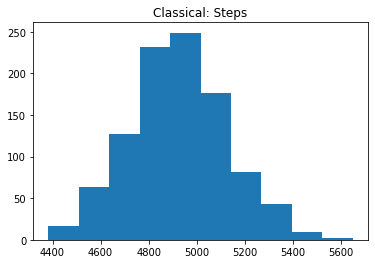

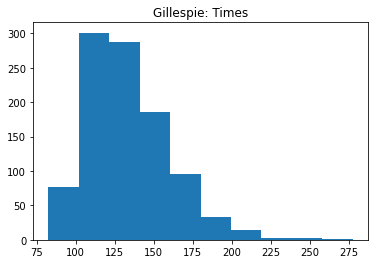

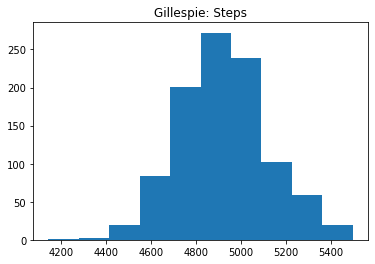

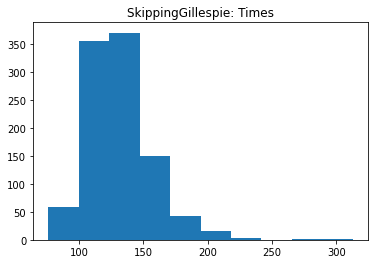

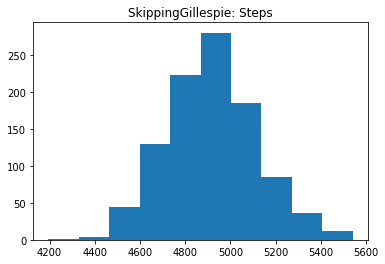

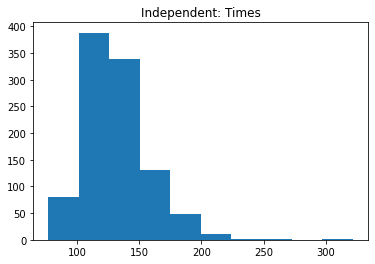

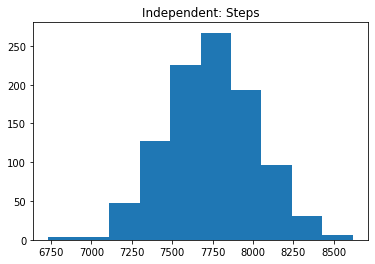

In [15]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    simulate_time_steps(algorithm, speciation=0.1, seeds=seeds, sample=1.0, size=10, radius=17, sigma=10.0)